In [61]:
# -*- coding: utf-8 -*- 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf-8')

# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })


In [16]:
train=pd.read_csv('train.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
test=pd.read_csv('test.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
train.head()

,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users,is_prolong
0,101969,"УСН, Доходы 6%",1994-03-26,5.0,0.0,0.0,0.0,0,2014-04-12,2.0,0.0,1.0
1,108477,ОСНО,2012-12-05,1.0,0.0,0.0,0.0,0,2014-09-22,5.0,0.0,0.0
2,101476,"УСН, Доходы 6%",2009-11-15,1.0,3.0,3.0,2.0,0,2016-05-04,0.0,0.0,1.0
3,102579,"УСН, Доходы за вычетом расходов 15%",2015-08-09,1.0,0.0,0.0,0.0,0,2015-09-24,0.0,0.0,0.0
4,103110,"УСН, Доходы за вычетом расходов 15%",2015-03-29,0.0,0.0,0.0,0.0,0,2015-03-04,4.0,0.0,0.0


In [17]:
train.drop(axis=0,index=train[train['regdt']=='0001-01-01 00:00:00.0000000']['regdt'].index.values,inplace=True)
train[['regdt','OrgCreationDate']]=train[['regdt','OrgCreationDate']].apply(pd.to_datetime)
train.dropna(axis=0, how='any',inplace=True)

columns = train.select_dtypes(['floating']).columns
train[columns] = train[columns].astype('int64')

train['regdt_year']=pd.DatetimeIndex(train['regdt']).year
train['regdt_month']=pd.DatetimeIndex(train['regdt']).month
train['regdt_day']=pd.DatetimeIndex(train['regdt']).day

train['OrgCreationDate_year']=pd.DatetimeIndex(train['OrgCreationDate']).year
train['OrgCreationDate_month']=pd.DatetimeIndex(train['OrgCreationDate']).month
train['OrgCreationDate_day']=pd.DatetimeIndex(train['OrgCreationDate']).day

train.drop(axis=1,columns=['regdt','OrgCreationDate'],inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7625
Data columns (total 16 columns):
id                          7598 non-null int64
taxactionSystem             7598 non-null object
workerCount                 7598 non-null int64
fssdccount                  7598 non-null int64
pfrdcCount                  7598 non-null int64
fnsdcCount                  7598 non-null int64
hasCloudCryptCertificate    7598 non-null int64
documentsCount              7598 non-null int64
cnt_users                   7598 non-null int64
is_prolong                  7598 non-null int64
regdt_year                  7598 non-null int64
regdt_month                 7598 non-null int64
regdt_day                   7598 non-null int64
OrgCreationDate_year        7598 non-null int64
OrgCreationDate_month       7598 non-null int64
OrgCreationDate_day         7598 non-null int64
dtypes: int64(15), object(1)
memory usage: 1009.1+ KB


In [4]:
train.head()

,id,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,is_prolong,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,101969,"УСН, Доходы 6%",5,0,0,0,0,2,0,1,1994,3,26,2014,4,12
1,108477,ОСНО,1,0,0,0,0,5,0,0,2012,12,5,2014,9,22
2,101476,"УСН, Доходы 6%",1,3,3,2,0,0,0,1,2009,11,15,2016,5,4
3,102579,"УСН, Доходы за вычетом расходов 15%",1,0,0,0,0,0,0,0,2015,8,9,2015,9,24
4,103110,"УСН, Доходы за вычетом расходов 15%",0,0,0,0,0,4,0,0,2015,3,29,2015,3,4


# Посмотрим на данные

Распределение целевой переменной: 	


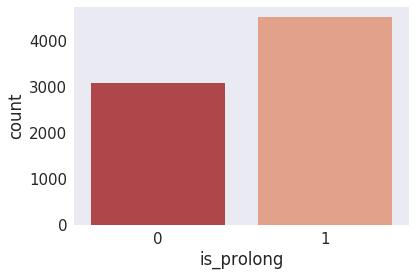

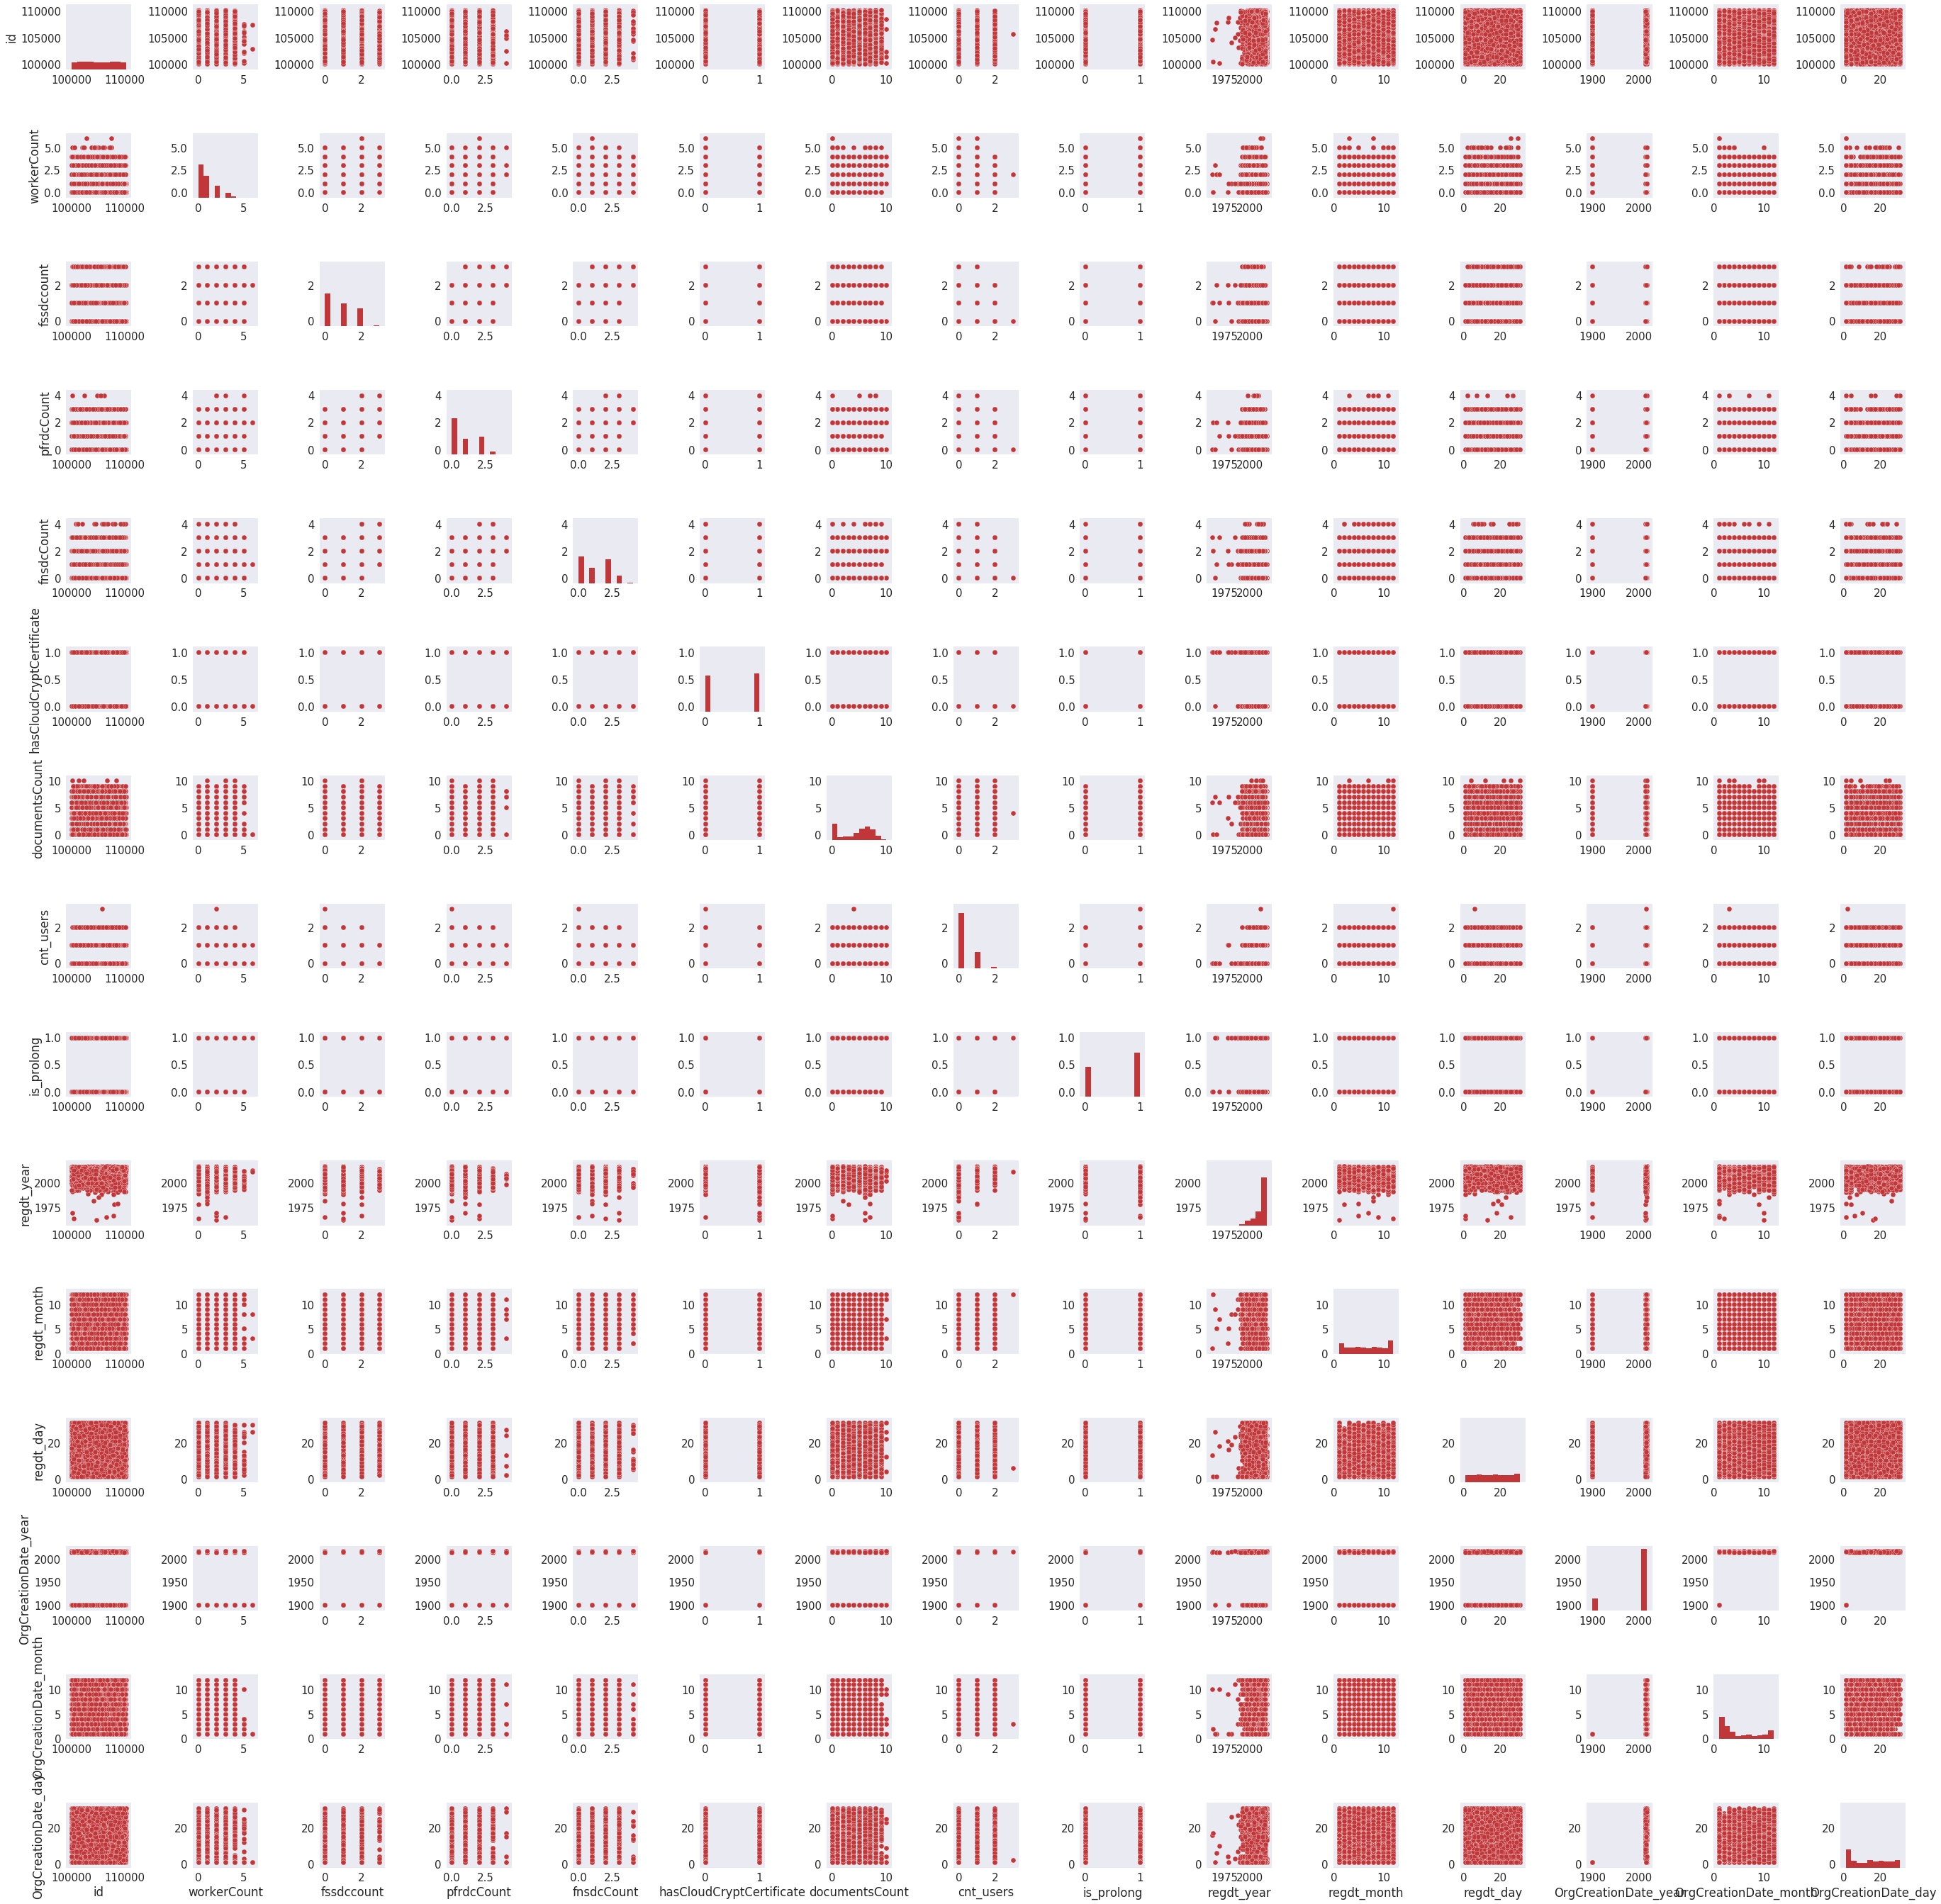

In [5]:
print 'Распределение целевой переменной: \t'
sns.countplot(train.is_prolong)

sns.pairplot(train)

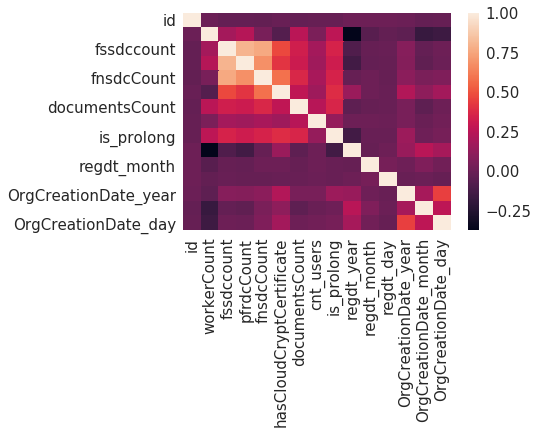

In [6]:
sns.heatmap(train.corr(method='spearman'));

In [18]:
train_y=train.is_prolong
train.drop(axis=1,columns=['is_prolong','id'],inplace=True)

## Label Encoding

{0: u'\u0415\u041d\u0412\u0414', 1: u'\u041e\u0421\u041d\u041e', 2: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3%', 3: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3% +\u0415\u041d\u0412\u0414', 4: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 4%', 5: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6%', 6: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6% +\u0415\u041d\u0412\u0414', 7: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10%', 8: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10% +\u0415\u041d\u0412\u0414', 9: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 12%', 10:

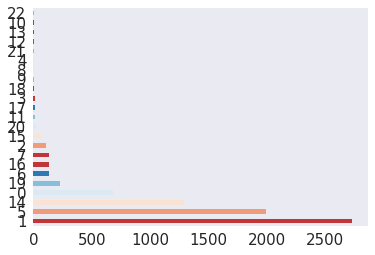

In [19]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['taxactionSystem']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [20]:
train['taxactionSystem'] = label_encoder.fit_transform(train['taxactionSystem']).astype('int')
train.head()

,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,5,5,0,0,0,0,2,0,1994,3,26,2014,4,12
1,1,1,0,0,0,0,5,0,2012,12,5,2014,9,22
2,5,1,3,3,2,0,0,0,2009,11,15,2016,5,4
3,14,1,0,0,0,0,0,0,2015,8,9,2015,9,24
4,14,0,0,0,0,0,4,0,2015,3,29,2015,3,4


## StandardScaler

In [28]:
scaler=StandardScaler()
train_sc=pd.DataFrame(scaler.fit_transform(train,train_y),columns=train.columns)

In [29]:
train_sc.head()

,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,-0.080411,3.980152,-0.988485,-0.885891,-1.126097,-1.031559,-0.760783,-0.549052,-3.090057,-1.066723,1.171311,0.426862,-0.279415,-0.153690
1,-0.788162,0.096478,-0.988485,-0.885891,-1.126097,-1.031559,0.333097,-0.549052,0.300985,1.545815,-1.211057,0.426862,1.083925,0.865987
2,-0.080411,0.096478,2.628713,2.298621,0.803992,-1.031559,-1.490036,-0.549052,-0.264189,1.255533,-0.076596,0.473730,-0.006747,-0.969431
3,1.512028,0.096478,-0.988485,-0.885891,-1.126097,-1.031559,-1.490036,-0.549052,0.866158,0.384687,-0.757273,0.450296,1.083925,1.069922
4,1.512028,-0.874440,-0.988485,-0.885891,-1.126097,-1.031559,-0.031529,-0.549052,0.866158,-1.066723,1.511649,0.450296,-0.552083,-0.969431


## Логистическая регрессия

In [96]:
lr=LogisticRegression(n_jobs=4)
parameters = {'C':np.logspace(-3, 1, 10)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_sc, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   2.78256e-03,   7.74264e-03,   2.15443e-02,
         5.99484e-02,   1.66810e-01,   4.64159e-01,   1.29155e+00,
         3.59381e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
print (clf.best_params_)

{'C': 0.1668100537200059}


In [59]:
pred=clf.predict(train_sc)
print (pred[:10])
print (train_y[:10].values)
print accuracy_score(train_y,pred)

[1 0 1 0 0 1 1 1 0 1]
[1 0 1 0 0 0 1 1 0 1]
0.755856804422


## Случайный лес

In [66]:
rnd_forest=RandomForestClassifier(n_jobs=4)
forest_params = {'max_depth': range(5, 15)
                #,'max_features': range(5, len(train.columns), 1)
                ,'n_estimators':range(50,150,10)
                }
search_forest=GridSearchCV(rnd_forest,forest_params)
search_forest.fit(train,train_y)
print (search_forest.best_params_)

pred_forest=search_forest.predict(train)
print (pred_forest[:10])
print (train_y[:10].values)
print accuracy_score(train_y,pred_forest)

{'n_estimators': 105, 'max_depth': 10}
[1 0 1 0 0 0 1 1 0 1]
[1 0 1 0 0 0 1 1 0 1]
0.883258752303


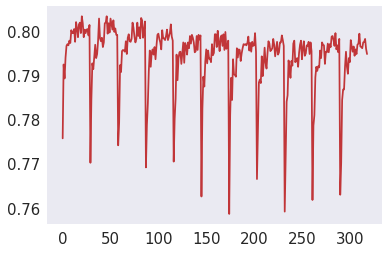

In [72]:
plt.pyplot.plot(search_forest.cv_results_['mean_test_score'])

## Градиентрный бустинг

In [73]:
g_boost=GradientBoostingClassifier()
bost_params = {'max_depth': range(5, 15)
              ,'n_estimators':range(50,150,5)}
search_boost=GridSearchCV(g_boost,bost_params)
search_boost.fit(train,train_y)
print (search_forest.best_params_)

pred_boost=search_boost.predict(train)
print (pred_boost[:10])
print (train_y[:10].values)
print accuracy_score(train_y,pred_boost)

{'n_estimators': 105, 'max_depth': 10}
[1 0 1 0 0 0 1 1 0 1]
[1 0 1 0 0 0 1 1 0 1]
0.837983679916


In [93]:
X,x_val,y,y_val=train_test_split(train,train_y,shuffle=True,random_state=17)

rnd_forest=RandomForestClassifier(n_jobs=4,n_estimators=105,max_depth=10)
rnd_forest.fit(X,y)
pred=rnd_forest.predict(x_val)
print accuracy_score(y_val,pred)

0.804210526316


In [94]:
g_boost=GradientBoostingClassifier(n_estimators=105,max_depth=10)
g_boost.fit(X,y)
pred_b=g_boost.predict(x_val)
print accuracy_score(y_val,pred_b)

0.78


In [98]:
lr=LogisticRegression(n_jobs=4,C=0.1668100)
lr.fit(X,y)
pred=lr.predict(x_val)
print accuracy_score(y_val,pred)

0.76
